In [ ]:
def calculate_first_sets(grammar):
    first_sets = {}

    # Initialize first sets with empty sets
    for non_terminal in grammar:
        first_sets[non_terminal] = set()

    # Helper function to calculate First set for a given symbol
    def calculate_first(symbol):
        if symbol.isalpha() and symbol.islower():
            # If the symbol is a terminal, add it to the First set
            first_sets[non_terminal].add(symbol)
        elif symbol in grammar:
            # If the symbol is a non-terminal, calculate its First set
            first_sets[non_terminal] |= first_sets[symbol]

    # Iterate through the grammar rules to calculate First sets
    for non_terminal, productions in grammar.items():
        for production in productions:
            for symbol in production:
                calculate_first(symbol)
                if symbol not in grammar or '0' not in first_sets[symbol]:
                    # If symbol is a non-terminal and does not derive '0', break the loop
                    break
            else:
                # If the loop completes without breaking, add '0' to the First set
                first_sets[non_terminal].add('0')

    return first_sets

def calculate_follow_sets(grammar, first_sets):
    follow_sets = {}

    # Initialize follow sets with empty sets
    for non_terminal in grammar:
        follow_sets[non_terminal] = set()

    # Add '$' to the follow set of the start symbol
    follow_sets[list(grammar.keys())[0]].add('$')

    # Helper function to calculate Follow set for a given symbol
    def calculate_follow(non_terminal, current_production, idx):
        if idx < len(current_production) - 1:
            # If the current symbol is not the last in the production, calculate First set
            for symbol in current_production[idx + 1:]:
                follow_sets[non_terminal] |= first_sets[symbol]
                if '0' not in first_sets[symbol]:
                    # If '0' is not in First set, break the loop
                    break
            else:
                # If the loop completes without breaking, add Follow set of the left-hand side
                follow_sets[non_terminal] |= follow_sets[current_non_terminal]

    # Iterate through the grammar rules to calculate Follow sets
    for non_terminal, productions in grammar.items():
        for idx, production in enumerate(productions):
            current_non_terminal = non_terminal
            for symbol in reversed(production):
                if symbol.isalpha() and symbol.islower():
                    # If the symbol is a terminal, move to the previous symbol
                    current_non_terminal = None
                elif symbol in grammar:
                    # If the symbol is a non-terminal, calculate Follow set
                    calculate_follow(non_terminal, production, idx)
                    current_non_terminal = symbol

    return follow_sets

def print_sets(first_sets, follow_sets):
    print("\nFirst Sets:")
    for non_terminal, first_set in first_sets.items():
        print(f"First({non_terminal}): {', '.join(sorted(first_set))}")

    print("\nFollow Sets:")
    for non_terminal, follow_set in follow_sets.items():
        print(f"Follow({non_terminal}): {', '.join(sorted(follow_set))}")

if __name__ == "__main__":
    # Grammar G: {E-> TE’, E’ -> +TE’ | 0, T-> FT’, T’-> *FT’|0, F-> (E) | id}
    grammar = {
        'E': ['T', 'E\''],
        'E\'': ['+', 'T', 'E\'', '0'],
        'T': ['F', 'T\''],
        'T\'': ['*', 'F', 'T\'', '0'],
        'F': ['(', 'E', ')', 'id']
    }

    first_sets = calculate_first_sets(grammar)
    follow_sets = calculate_follow_sets(grammar, first_sets)

    print_sets(first_sets, follow_sets)


In [ ]:
gram = {
	"E":["E+T","T"],
	"T":["T*F","F"],
	"F":["(E)","id"]
}

def removeDirectLR(gramA, A):
	temp = gramA[A]
	tempCr = []
	tempInCr = []
	for i in temp:
		if i[0] == A:
			#tempInCr.append(i[1:])
			tempInCr.append(i[1:]+[A+"'"])
		else:
			#tempCr.append(i)
			tempCr.append(i+[A+"'"])
	tempInCr.append(["e"])
	gramA[A] = tempCr
	gramA[A+"'"] = tempInCr
	return gramA


def checkForIndirect(gramA, a, ai):
	if ai not in gramA:
		return False
	if a == ai:
		return True
	for i in gramA[ai]:
		if i[0] == ai:
			return False
		if i[0] in gramA:
			return checkForIndirect(gramA, a, i[0])
	return False

def rep(gramA, A):
	temp = gramA[A]
	newTemp = []
	for i in temp:
		if checkForIndirect(gramA, A, i[0]):
			t = []
			for k in gramA[i[0]]:
				t=[]
				t+=k
				t+=i[1:]
				newTemp.append(t)

		else:
			newTemp.append(i)
	gramA[A] = newTemp
	return gramA

def rem(gram):
	c = 1
	conv = {}
	gramA = {}
	revconv = {}
	for j in gram:
		conv[j] = "A"+str(c)
		gramA["A"+str(c)] = []
		c+=1

	for i in gram:
		for j in gram[i]:
			temp = []
			for k in j:
				if k in conv:
					temp.append(conv[k])
				else:
					temp.append(k)
			gramA[conv[i]].append(temp)


	for i in range(c-1,0,-1):
		ai = "A"+str(i)
		for j in range(0,i):
			aj = gramA[ai][0][0]
			if ai!=aj :
				if aj in gramA and checkForIndirect(gramA,ai,aj):
					gramA = rep(gramA, ai)

	for i in range(1,c):
		ai = "A"+str(i)
		for j in gramA[ai]:
			if ai==j[0]:
				gramA = removeDirectLR(gramA, ai)
				break

	op = {}
	for i in gramA:
		a = str(i)
		for j in conv:
			a = a.replace(conv[j],j)
		revconv[i] = a

	for i in gramA:
		l = []
		for j in gramA[i]:
			k = []
			for m in j:
				if m in revconv:
					k.append(m.replace(m,revconv[m]))
				else:
					k.append(m)
			l.append(k)
		op[revconv[i]] = l

	return op

result = rem(gram)


def first(gram, term):
	a = []
	if term not in gram:
		return [term]
	for i in gram[term]:
		if i[0] not in gram:
			a.append(i[0])
		elif i[0] in gram:
			a += first(gram, i[0])
	return a

firsts = {}
for i in result:
	firsts[i] = first(result,i)
	print(f'First({i}):',firsts[i])


def follow(gram, term):
	a = []
	for rule in gram:
		for i in gram[rule]:
			if term in i:
				temp = i
				indx = i.index(term)
				if indx+1!=len(i):
					if i[-1] in firsts:
						a+=firsts[i[-1]]
					else:
						a+=[i[-1]]
				else:
					a+=["e"]
				if rule != term and "e" in a:
					a+= follow(gram,rule)
	return a

follows = {}
for i in result:
	follows[i] = list(set(follow(result,i)))
	if "e" in follows[i]:
		follows[i].pop(follows[i].index("e"))
	follows[i]+=["$"]
	print(f'Follow({i}):',follows[i])

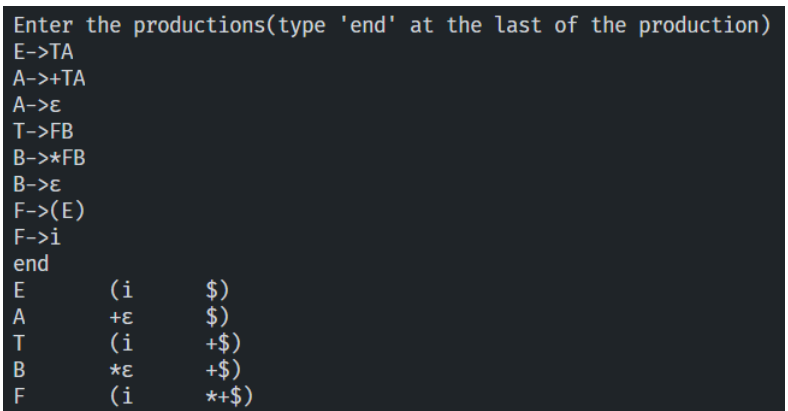
<br> Below code output like this

In [ ]:
import sys
sys.setrecursionlimit(60)

def first(string):
    #print("first({})".format(string))
    first_ = set()
    if string in non_terminals:
        alternatives = productions_dict[string]

        for alternative in alternatives:
            first_2 = first(alternative)
            first_ = first_ |first_2

    elif string in terminals:
        first_ = {string}

    elif string=='' or string=='@':
        first_ = {'@'}

    else:
        first_2 = first(string[0])
        if '@' in first_2:
            i = 1
            while '@' in first_2:
                #print("inside while")

                first_ = first_ | (first_2 - {'@'})
                #print('string[i:]=', string[i:])
                if string[i:] in terminals:
                    first_ = first_ | {string[i:]}
                    break
                elif string[i:] == '':
                    first_ = first_ | {'@'}
                    break
                first_2 = first(string[i:])
                first_ = first_ | first_2 - {'@'}
                i += 1
        else:
            first_ = first_ | first_2


    #print("returning for first({})".format(string),first_)
    return  first_


def follow(nT):
    #print("inside follow({})".format(nT))
    follow_ = set()
    #print("FOLLOW", FOLLOW)
    prods = productions_dict.items()
    if nT==starting_symbol:
        follow_ = follow_ | {'$'}
    for nt,rhs in prods:
        #print("nt to rhs", nt,rhs)
        for alt in rhs:
            for char in alt:
                if char==nT:
                    following_str = alt[alt.index(char) + 1:]
                    if following_str=='':
                        if nt==nT:
                            continue
                        else:
                            follow_ = follow_ | follow(nt)
                    else:
                        follow_2 = first(following_str)
                        if '@' in follow_2:
                            follow_ = follow_ | follow_2-{'@'}
                            follow_ = follow_ | follow(nt)
                        else:
                            follow_ = follow_ | follow_2
    #print("returning for follow({})".format(nT),follow_)
    return follow_





no_of_terminals=int(input("Enter no. of terminals: "))

terminals = []

print("Enter the terminals :")
for _ in range(no_of_terminals):
    terminals.append(input())

no_of_non_terminals=int(input("Enter no. of non terminals: "))

non_terminals = []

print("Enter the non terminals :")
for _ in range(no_of_non_terminals):
    non_terminals.append(input())

starting_symbol = input("Enter the starting symbol: ")

no_of_productions = int(input("Enter no of productions: "))

productions = []

print("Enter the productions:")
for _ in range(no_of_productions):
    productions.append(input())


#print("terminals", terminals)

#print("non terminals", non_terminals)

#print("productions",productions)


productions_dict = {}

for nT in non_terminals:
    productions_dict[nT] = []


#print("productions_dict",productions_dict)

for production in productions:
    nonterm_to_prod = production.split("->")
    alternatives = nonterm_to_prod[1].split("/")
    for alternative in alternatives:
        productions_dict[nonterm_to_prod[0]].append(alternative)

#print("productions_dict",productions_dict)

#print("nonterm_to_prod",nonterm_to_prod)
#print("alternatives",alternatives)


FIRST = {}
FOLLOW = {}

for non_terminal in non_terminals:
    FIRST[non_terminal] = set()

for non_terminal in non_terminals:
    FOLLOW[non_terminal] = set()

#print("FIRST",FIRST)

for non_terminal in non_terminals:
    FIRST[non_terminal] = FIRST[non_terminal] | first(non_terminal)

#print("FIRST",FIRST)


FOLLOW[starting_symbol] = FOLLOW[starting_symbol] | {'$'}
for non_terminal in non_terminals:
    FOLLOW[non_terminal] = FOLLOW[non_terminal] | follow(non_terminal)

#print("FOLLOW", FOLLOW)

print("{: ^20}{: ^20}{: ^20}".format('Non Terminals','First','Follow'))
for non_terminal in non_terminals:
    print("{: ^20}{: ^20}{: ^20}".format(non_terminal,str(FIRST[non_terminal]),str(FOLLOW[non_terminal])))